## As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

## In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

## Acquire bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, and fips from the zillow database for all 'Single Family Residential' properties.

## Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.

## Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your wrangle.py file. Name your final function wrangle_zillow.

# Imports

In [1]:
import pandas as pd

from env import user, password, host

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
query = """
            
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")"""
    
df = pd.read_sql(query, url)
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2152859,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2152860,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152861,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


# Prepare

## Are there any Null values?

In [3]:
# get total of null values for each row
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

* dropping rows with nulls in bedroomcnt and bathroomcnt because there are very few of them
* dropping rows with nulls in taxvaluedollorcnt, training the model to asociate data with a calculated column seems dubious

In [4]:
# drop rows that are nulls in bedroomcnt, bathroomcnt, taxvaluedollarcnt
df = df.dropna(subset = ['bedroomcnt','bathroomcnt', 'taxvaluedollarcnt'])

In [5]:
df.isnull().sum()

bedroomcnt                         0
bathroomcnt                        0
calculatedfinishedsquarefeet    8100
taxvaluedollarcnt                  0
yearbuilt                       8959
taxamount                       3971
fips                               0
dtype: int64

* dropping column taxamount because it contains target leak

In [6]:
# drop taxamount
df = df.drop(columns = 'taxamount')

In [7]:
df.isnull().sum()

bedroomcnt                         0
bathroomcnt                        0
calculatedfinishedsquarefeet    8100
taxvaluedollarcnt                  0
yearbuilt                       8959
fips                               0
dtype: int64

In [8]:
# consider imputing year built
df.yearbuilt.value_counts()

1955.0    84404
1950.0    71686
1954.0    69161
1953.0    62339
1956.0    61938
          ...  
1879.0        1
1877.0        1
1855.0        1
1874.0        1
1823.0        1
Name: yearbuilt, Length: 153, dtype: int64

* because the number of rows with missing data in yearbuilt is grater than the number of rows with the most frequent value, imputing the data using any one value would significantly skew the data I will therefore drop the rows containing nulls in this column

In [9]:
df = df.dropna(subset = ['yearbuilt'])

df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet    598
taxvaluedollarcnt                 0
yearbuilt                         0
fips                              0
dtype: int64

In [10]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
count,2143401,2143401,2142803,2143401,2143401,2143401
mean,3,2,1863,460662,1961,6048
std,1,1,1222,678990,22,20
min,0,0,1,1,1801,6037
25%,3,2,1257,188822,1949,6037
50%,3,2,1623,328011,1958,6037
75%,4,3,2208,534504,1976,6059
max,25,32,952576,90188462,2016,6111


In [11]:
pd.reset_option('display.float_format')

* Given the extream outliers, I plan on imputing calculatedfinishedsquarefeet based on the median or mode once the data is split

## Are the column data types correct?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143401 entries, 4 to 2152863
Data columns (total 6 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   fips                          float64
dtypes: float64(6)
memory usage: 114.5 MB


In [13]:
# get value counts and decide on data types
cols = df.columns

for col in cols:
    
    print(col.upper())
    print(df[col].value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print()

BEDROOMCNT
3.0     963850
4.0     633983
2.0     335086
5.0     150778
6.0      25153
1.0      23055
0.0       5097
7.0       4802
8.0       1106
9.0        290
10.0       121
11.0        34
13.0        15
12.0        12
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: bedroomcnt, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

BATHROOMCNT
2.00     943272
3.00     422656
1.00     413782
2.50     142846
4.00      82123
1.50      31166
3.50      28471
5.00      28351
4.50      19476
6.00      10746
5.50       6202
0.00       4950
7.00       4393
8.00       1688
6.50       1330
9.00        712
7.50        382
10.00       325
11.00       145
8.50        108
12.00        73
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
14.50         1
32.00         1
19.50         1
19.00         1
Name: bathroomc

* casting fips and year built as an object because it is a numerical represintation of a catagorical value
* leaving the rest as floats

In [14]:
df.fips = df.fips.astype(object)
df.yearbuilt = df.yearbuilt.astype(object)
df.bedroomcnt = df.bedroomcnt.astype(int)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143401 entries, 4 to 2152863
Data columns (total 6 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    int64  
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     object 
 5   fips                          object 
dtypes: float64(3), int64(1), object(2)
memory usage: 114.5+ MB


## Do I like the column names?

In [16]:
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'fips'],
      dtype='object')

In [17]:
# renaming column names to one's I like better
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})

df.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'fips'], dtype='object')

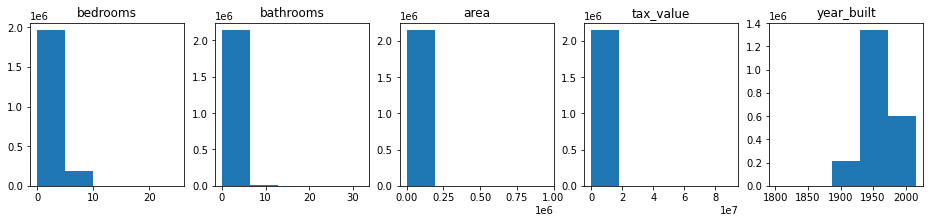

In [18]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col != 'fips']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

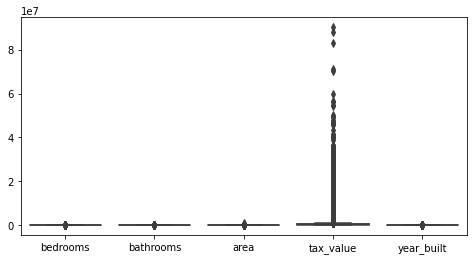

In [19]:
plt.figure(figsize=(8,4))

sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

## Split the data

In [20]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

## Impute the data

In [21]:
imputer = SimpleImputer(strategy='median')  # build imputer

imputer.fit(train[['area']]) # fit to train

# transform the data
train[['area']] = imputer.transform(train[['area']])
validate[['area']] = imputer.transform(validate[['area']])
test[['area']] = imputer.transform(test[['area']])

In [22]:
train.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [23]:
validate.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [24]:
test.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
fips          0
dtype: int64

In [25]:
train

,bedrooms,bathrooms,area,tax_value,year_built,fips
1304496,3,2.0,1242.0,60625.0,1936.0,6037.0
1232706,2,1.0,836.0,52965.0,1949.0,6037.0
1849408,3,2.0,3049.0,104973.0,1971.0,6059.0
1879936,4,3.0,2635.0,894657.0,1987.0,6037.0
50505,4,3.0,2563.0,331065.0,1982.0,6037.0
...,...,...,...,...,...,...
2091693,2,1.0,1066.0,25424.0,1921.0,6037.0
1561515,5,3.0,3088.0,534598.0,1998.0,6111.0
134013,3,1.0,1032.0,295000.0,1924.0,6037.0
1358019,3,2.0,1591.0,457000.0,1967.0,6037.0


In [26]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
train.describe()

,bedrooms,bathrooms,area,tax_value
count,1200304,1200304,1200304,1200304
mean,3,2,1863,461730
std,1,1,1303,696377
min,0,0,1,1
25%,3,2,1257,189150
50%,3,2,1623,328471
75%,4,3,2207,534297
max,18,32,952576,90188462


In [27]:
##################################################Wrangle.py###################################################

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from env import user, password, host

#**************************************************Acquire*******************************************************

def acquire_zillow():
    
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"
    
    query = """
            
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017

    LEFT JOIN propertylandusetype USING(propertylandusetypeid)

    WHERE propertylandusedesc IN ("Single Family Residential",                       
                                  "Inferred Single Family Residential")"""

    # get dataframe of data
    df = pd.read_sql(query, url)
    
    
    # renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'area',
                              'taxvaluedollarcnt':'tax_value', 
                              'yearbuilt':'year_built',
                              'taxamount':'tax_amount'})
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)
        
        
def get_box(df):
    
    plt.figure(figsize=(8,4))

    sns.boxplot(data=df.drop(columns=['fips', 'year_built']))
    plt.show()
        
#**************************************************Prepare*******************************************************

def prepare_zillow(df):
    
    # drop rows that are nulls 
    df = df.dropna(subset = ['bedrooms','bathrooms', 'year_built', 'tax_value'])
    
    # drop taxamount
    df = df.drop(columns = 'tax_amount')
    
    # converting column datatypes
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    df.bedrooms = df.bedrooms.astype(int)
    
    print(df.shape)
    
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # impute median value 
    imputer = SimpleImputer(strategy='median') 

    imputer.fit(train[['area']])

    train[['area']] = imputer.transform(train[['area']])        
    validate[['area']] = imputer.transform(validate[['area']])  
    test[['area']] = imputer.transform(test[['area']])          
    
    return train, validate, test    


#**************************************************Wrangle*******************************************************

def wrangle_zillow():
    
    train, validate, test = prepare_zillow(acquire_zillow())
    
    return train, validate, test

In [28]:
train, validate, test, = wrangle_zillow()

(2142916, 6)


In [29]:
train

,bedrooms,bathrooms,area,tax_value,year_built,fips
720055,4,2,1808,644683,1956,6059
89347,4,5,4227,1586297,1959,6037
1043548,3,2,1935,669762,1987,6059
1025521,3,1,1038,120120,1945,6037
1043398,3,2,1153,479891,1956,6059
...,...,...,...,...,...,...
1187583,5,4,2843,859090,1954,6037
1313197,4,2,1942,574097,1999,6059
1301377,4,2,2217,238213,1972,6059
1000314,3,3,2363,119129,1993,6059


In [30]:
validate

,bedrooms,bathrooms,area,tax_value,year_built,fips
2040567,3,2,1162,775000,1955,6037
2109921,3,2,2102,90153,1949,6111
479226,3,2,1474,632457,1969,6037
280682,3,2,1907,535698,1961,6111
1603669,4,3,2742,810581,1992,6059
...,...,...,...,...,...,...
1611505,3,1,1173,60017,1953,6037
1438364,3,2,1232,336281,1955,6037
1074546,2,2,1224,255587,1976,6059
654384,9,3,3800,1011535,1956,6059


In [31]:
test

,bedrooms,bathrooms,area,tax_value,year_built,fips
823653,3,1,1628,397049,195,6037
228989,4,3,2754,774000,199,6037
1529721,4,2,1320,310020,1972,6111
2022915,4,3,3282,741863,1977,6059
1544036,3,3,2012,1183029,1956,6037
...,...,...,...,...,...,...
1466984,3,2,1488,125389,1974,6037
1459340,4,2,1705,291943,1952,6037
510240,3,2,1512,1174888,1931,6037
200824,3,2,1260,55872,1959,6037


# Formal Notebook

# Imports

In [32]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

from env import user, password, host
import wrangle_exercise as w

# Acquire

* Data acquired from Zillow database
* Query selected single unit properties observed in 2017
* Dataframe contained aprox. 2 million rows and 7 columns
* Renamed some of the columns

In [33]:
df = acquire_zillow()

## Veriable Distributions

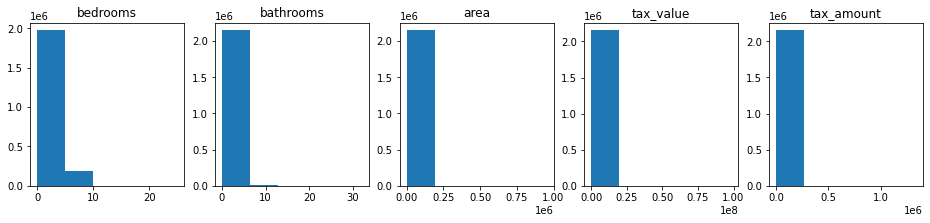

In [35]:
get_hist(df)

* Takeaways

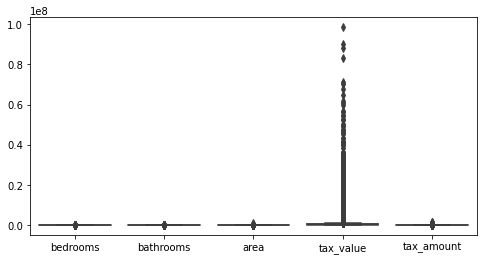

In [36]:
get_box(df)

* Takeaways

# Prepare

* dropped rows with nulls in bedrooms and bathrooms because very fer lines were effected
* dropped rows with nulls in year_built because imputing could skew the data due to the large number of rows containing nulls in that column
* dropped rows with nulls in tax_value imputing the target variable seems dubious
* dropped tax_ammount as it likely contains target leak. You must first know the tax_value of a property before you can calculate the correct tax ammount. Because we are predicting tax_value we will not know what the tax_amount is untill after the model has made it's predictions 

In [37]:
train, validate, test = prepare_zillow(df)

(2142916, 6)


In [38]:
train.shape

(1200032, 6)

In [39]:
validate.shape

(514300, 6)

In [40]:
test.shape

(428584, 6)